# Word2Vec

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 266, done.
remote: Total 266 (delta 0), reused 0 (delta 0), pack-reused 266
Receiving objects: 100% (266/266), 42.13 MiB | 17.60 MiB/s, done.
Resolving deltas: 100% (129/129), done.
     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 1.7MB 10.0MB/s 
     |████████████████████████████████| 307kB 44.2MB/s 
     |████████████████████████████████| 7.1MB 34.3MB/s 
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp36-cp36m-linux_x86_64.whl size=5625275 sha256=8a2fd01be8b769a3193417d9b4dabd0cd8c64c2a29f8ddc96c0f1ddc704b1ace
  Stored in directory: /root/.cache/pip/wheels/0c/9d/db/6d3404c33da5b7adb6c6972853efb6a27649d3ba15f7e9bebb
  Created wheel for intervaltree: filename=intervaltree-3.0.2-cp36-none-any.whl size=25791 sha256=6d5c8d8cc9461c9bd7f795f6b63b75b6f93aaf5a1b985b584d602a26bfa915ba
  Stored in directory: /root/.cache/pip/wheels/08/99/c0/5a5942f5b9567c59c14aac76f95a70bf11

In [0]:
%load_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, texts_to_token_ids, \
    PaddedSequenceDataset, Embeddings
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed
from dlnlputils.visualization import plot_vectors

init_random_seed()

## Загрузка данных и подготовка корпуса

In [4]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
full_dataset = list(pd.read_csv('./stepik-dl-nlp/datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 125344
Тестовая выборка 53719

1/4 cup sour cream
10 ounces swordfish, red snapper or other firm-fleshed fish
1 tablespoon minced basil leaves
Handful fresh parsley, finely minced
4 ounces lard or butter, plus more for brushing tops
4 to 5 green cardamom pods
1 stick ( 1/4 pound) unsalted butter, softened
1/4 teaspoon red pepper flakes, preferably Turkish or Aleppo (see note), more to taste
1 tablespoon fresh lemon juice
1/4 cup scallions, thinly sliced


In [5]:
# токенизируем
train_tokenized = tokenize_corpus(train_source)
test_tokenized = tokenize_corpus(test_source)
print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))

sour cream
ounces swordfish snapper other firm fleshed fish
tablespoon minced basil leaves
handful fresh parsley finely minced
ounces lard butter plus more brushing tops
green cardamom pods
stick pound unsalted butter softened
teaspoon pepper flakes preferably turkish aleppo note more taste
tablespoon fresh lemon juice
scallions thinly sliced


In [6]:
# строим словарь
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 2267
[('<PAD>', 0), ('tablespoons', 1), ('teaspoon', 2), ('chopped', 3), ('salt', 4), ('pepper', 5), ('cups', 6), ('ground', 7), ('fresh', 8), ('tablespoon', 9)]


In [7]:
# отображаем в номера токенов
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent)
                for sent in train_token_ids[:10]))

222 52
22 878 574 127 246 707 181
9 19 88 33
517 8 43 15 19
22 586 20 45 47 648 649
59 329 535
200 12 50 20 266
2 5 140 78 1208 735 153 47 10
9 8 31 25
98 65 27


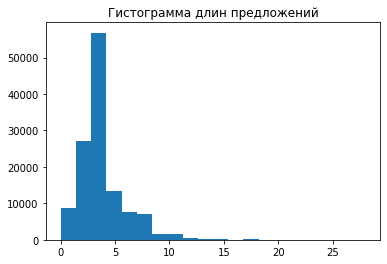

In [8]:
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');

In [9]:
MAX_SENTENCE_LEN = 20
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_token_ids,
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_dataset[0])

(tensor([222,  52,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]), tensor(0))


## Алгоритм обучения - Skip Gram Negative Sampling

**Skip Gram** - предсказываем соседние слова по центральному слову

**Negative Sampling** - аппроксимация softmax

$$ W, D \in \mathbb{R}^{Vocab \times EmbSize} $$

$$ \sum_{CenterW_i} P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) \rightarrow \max_{W,D} $$

$$ P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) = \prod_j P(CtxW_j | CenterW_i; W, D) $$
    
$$ P(CtxW_j | CenterW_i; W, D) = \frac{e^{w_i \cdot d_j}} { \sum_{j=1}^{|V|} e^{w_i \cdot d_j}} = softmax \simeq \frac{e^{w_i \cdot d_j^+}} { \sum_{j=1}^{k} e^{w_i \cdot d_j^-}}, \quad k \ll |V| $$

In [24]:
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

In [0]:
class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

## Обучение

In [0]:
trainer = SkipGramNegativeSamplingTrainer(len(vocabulary), 100, MAX_SENTENCE_LEN,
                                          radius=5, negative_samples_n=25)

In [28]:
best_val_loss, best_model = train_eval_loop(trainer,
                                            train_dataset,
                                            test_dataset,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=10,
                                            batch_size=8,
                                            device='cpu',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Эпоха: 2 итераций, 0.02 сек
Среднее значение функции потерь на обучении 0.9868252873420715
Среднее значение функции потерь на валидации 0.9875874482067503
Новая лучшая модель!

Эпоха 1
Эпоха: 2 итераций, 0.02 сек
Среднее значение функции потерь на обучении 0.9855734705924988
Среднее значение функции потерь на валидации 0.9874087922358282
Новая лучшая модель!

Эпоха 2
Эпоха: 2 итераций, 0.01 сек
Среднее значение функции потерь на обучении 0.9828388094902039
Среднее значение функции потерь на валидации 0.9871387637380513
Новая лучшая модель!

Эпоха 3
Эпоха: 2 итераций, 0.02 сек
Среднее значение функции потерь на обучении 0.9800149202346802
Среднее значение функции потерь на валидации 0.9867429672029598
Новая лучшая модель!

Эпоха 4
Эпоха: 2 итераций, 0.02 сек
Среднее значение функции потерь на обучении 0.9761469066143036
Среднее значение функции потерь на валидации 0.9862066373839276
Новая лучшая модель!

Эпоха 5
Эпоха: 2 итераций, 0.02 сек
Среднее значение функции потерь на обуч

In [0]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch.save(trainer.state_dict(), 'stepik-dl-nlp/models/sgns.pth')

In [34]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
trainer.load_state_dict(torch.load('stepik-dl-nlp/models/sgns.pth'))

<All keys matched successfully>

## Исследуем характеристики полученных векторов

In [0]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [40]:
embeddings.most_similar('cheese')

[('cheese', 0.9963074),
 ('remove', 0.3375049),
 ('uncured', 0.29478022),
 ('gallon', 0.28644225),
 ('boiled', 0.27201077),
 ('sturdy', 0.2677288),
 ('chanterelles', 0.25551873),
 ('quart', 0.25222448),
 ('grape', 0.2502588),
 ('canola', 0.24761528)]

In [41]:
embeddings.analogy('cake', 'cacao', 'cheese')

[('cheese', 1.3018416),
 ('cacao', 1.208836),
 ('cranberry', 0.631156),
 ('cannellini', 0.62774444),
 ('scented', 0.5598503),
 ('grape', 0.54509866),
 ('even', 0.53428555),
 ('uncured', 0.52435416),
 ('optional', 0.5227102),
 ('remove', 0.51869744)]

In [49]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(18, 100)


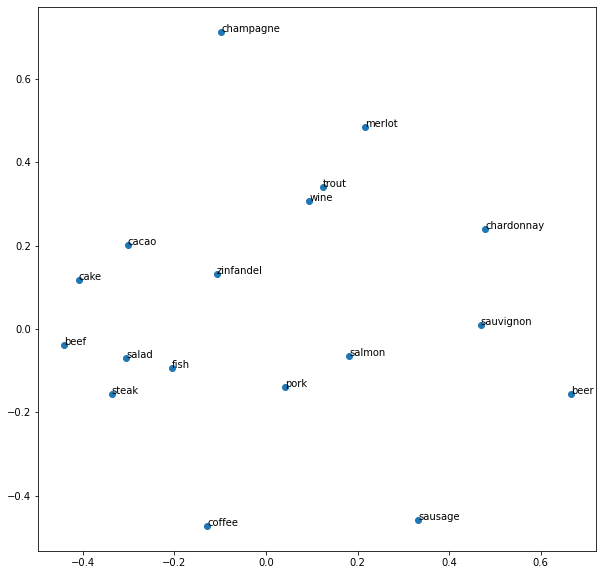

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

## Обучение Word2Vec с помощью Gensim

In [0]:
import gensim

In [0]:
word2vec = gensim.models.Word2Vec(sentences=train_tokenized, size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, iter=10)

In [53]:
word2vec.wv.most_similar('chicken')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('duck', 0.720364511013031),
 ('thighs', 0.7033222317695618),
 ('pheasant', 0.6953794956207275),
 ('simmering', 0.6849023103713989),
 ('drumsticks', 0.6842516660690308),
 ('turkey', 0.6799957752227783),
 ('breast', 0.6527578830718994),
 ('defatted', 0.6497312784194946),
 ('wings', 0.6493996977806091),
 ('thigh', 0.6451897621154785)]

In [0]:
gensim_words = [w for w in test_words if w in word2vec.wv.vocab]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

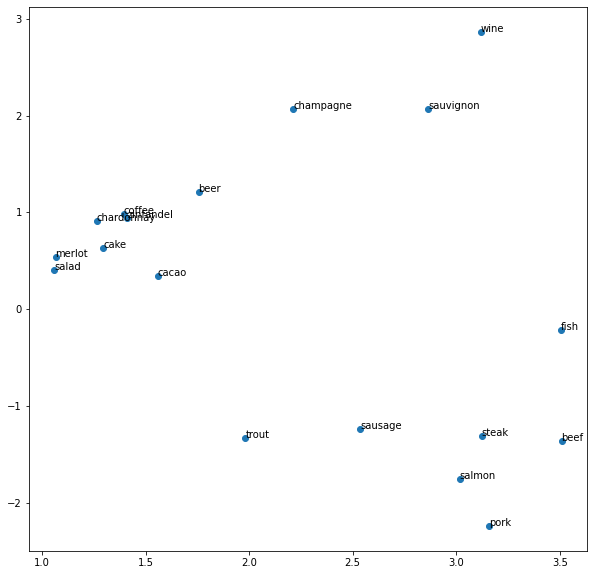

In [61]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

## Загрузка предобученного Word2Vec

Источники готовых векторов:

https://rusvectores.org/ru/ - для русского языка

https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ - много разных языков

In [0]:
import gensim.downloader as api

In [63]:
available_models = api.info()['models'].keys()
print('\n'.join(available_models))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [64]:
pretrained = api.load('word2vec-google-news-300')  # > 1.5 GB!

[=================================================-] 99.4% 1653.1/1662.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [69]:
pretrained.most_similar('tramp')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('tramps', 0.6600168347358704),
 ('vagrant', 0.5599273443222046),
 ('hobo', 0.5299054980278015),
 ('floozie', 0.5202133059501648),
 ('floozy', 0.5194193124771118),
 ('drunkard', 0.5175323486328125),
 ('poncing', 0.5168675184249878),
 ('wench', 0.5150554776191711),
 ('nympho', 0.5146324634552002),
 ('boozehound', 0.5140563249588013)]

In [74]:
pretrained.most_similar(positive=['man', 'woman'], negative=['ethernet'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('girl', 0.6209738254547119),
 ('teenage_girl', 0.6106643080711365),
 ('boy', 0.6036961078643799),
 ('teenager', 0.6008946299552917),
 ('teen_ager', 0.5279368758201599),
 ('victim', 0.49982935190200806),
 ('teenaged_girl', 0.4899665117263794),
 ('lady', 0.4860706031322479),
 ('men', 0.4836862087249756),
 ('person', 0.48299121856689453)]

In [0]:
pretrained_words = [w for w in test_words if w in pretrained.vocab]
pretrained_vectors = np.stack([pretrained[w] for w in pretrained_words])

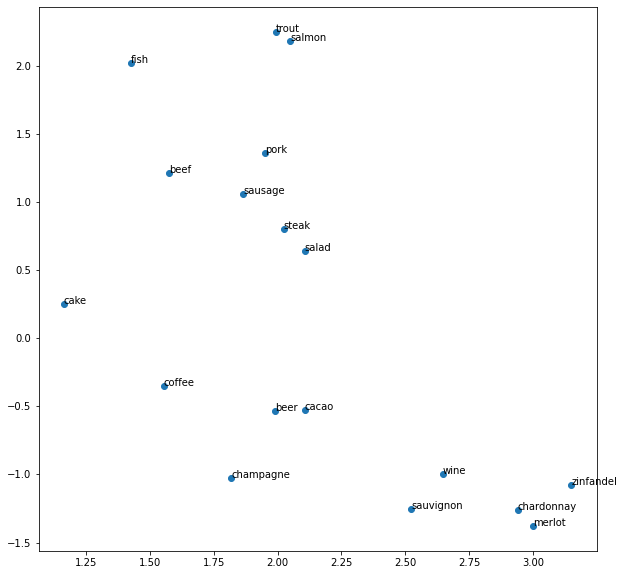

In [76]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(pretrained_vectors, test_words, how='svd', ax=ax)

## Заключение

* Реализовали Skip Gram Negative Sampling на PyTorch
* Обучили на корпусе рецептов
    * Сходство слов модель выучила неплохо
    * Для аналогий мало данных
* Обучили SGNS с помощью библиотеки Gensim
* Загрузили веса Word2Vec, полученные с помощью большого корпуса (GoogleNews)
    * Списки похожих слов отличаются!
    * Аналогии работают